# Yelp Reviews Classification
<b>Area:</b> Natural Language Processing, classification problem.

## The objective:
classify Yelp Reviews into five categories: one to five stars. 
- - -
<b>Tools:</b> python pandas, sklearn, seaborn
<br>
<b>Algorithm:</b> the multinomial Naive Bayes classifier 
<br><br>
This showcase project is an extension of a capstone project in the scope of the [Python for Data Science and Machine Learning Bootcamp"](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp) MOOC.

- - -
## Data
[Yelp Review dataset](https://www.kaggle.com/c/yelp-recsys-2013).

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('yelp.csv')

In [4]:
df.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


#### Introducing a text_length feature

In [6]:
df['text_length'] = df['text'].apply(len)

In [7]:
df.describe()

,stars,cool,useful,funny,text_length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300,710.738700
std,1.214636,2.067861,2.336647,1.907942,617.399827
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,294.000000
50%,4.000000,0.000000,1.000000,0.000000,541.500000
75%,5.000000,1.000000,2.000000,1.000000,930.000000
max,5.000000,77.000000,76.000000,57.000000,4997.000000


#### How many reviews available for each class?

In [8]:
df['stars'].value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

#### Most reviewers gave either 4 or 5 stars

- - -
## Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

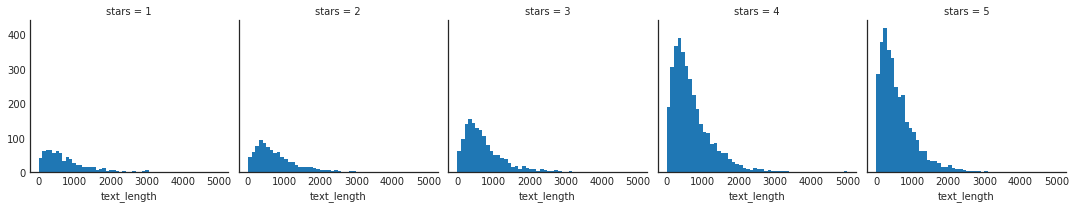

In [10]:
sns.set_style('white')
g = sns.FacetGrid(df,col='stars')
g = g.map(plt.hist,'text_length',bins=50)

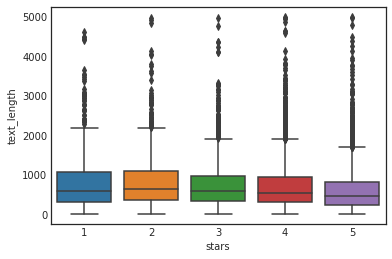

In [11]:
sns.boxplot(x='stars',y='text_length',data=df)

#### The text length doesn't show any significant class dependence
- - -

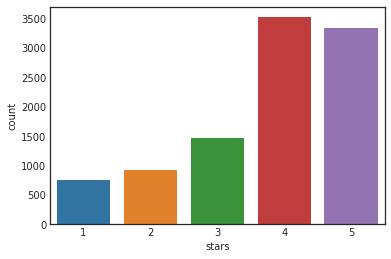

In [11]:
sns.countplot(x='stars',data=df)

In [12]:
df.groupby(by='stars').mean()

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [13]:
df_corr = df.groupby(by='stars').mean().corr()
df_corr

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


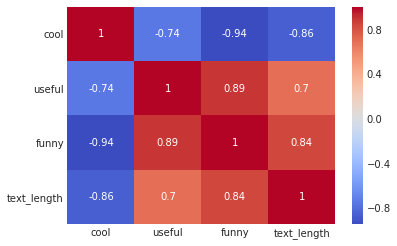

In [14]:
sns.heatmap(df_corr, annot=True, cmap='coolwarm')

- - -
## NLP Feature Extraction

In [12]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
def text_preprocess(mess):
    nopunc = ''
    for char in mess:
        if char not in string.punctuation:
            nopunc+=char
    result = []
    for word in nopunc.split():
        word = word.lower()
        if word in stopwords.words('english'): continue
        elif (len(word)<2): continue
        elif (word==' '): continue    
        else: result.append(word)
    result = ' '.join(result)
    return result

#### Here is original the first text entry:

In [171]:
df.at[0,'text']

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

#### And here is the same text entry preprocessed:

In [16]:
text_preprocess(df.at[0,'text'])

'wife took birthday breakfast excellent weather perfect made sitting outside overlooking grounds absolute pleasure waitress excellent food arrived quickly semibusy saturday morning looked like place fills pretty quickly earlier get better favor get bloody mary phenomenal simply best ive ever im pretty sure use ingredients garden blend fresh order amazing everything menu looks excellent white truffle scrambled eggs vegetable skillet tasty delicious came pieces griddled bread amazing absolutely made meal complete best toast ive ever anyway cant wait go back'

In [18]:
df['text_preprocessed'] = df['text'].apply(lambda x: text_preprocess(x))

- - -
## NLP Classification

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,log_loss

In [26]:
X = df['text_preprocessed']
y = df['stars']
vectorizer = CountVectorizer(min_df=5, max_features = 100)

In [27]:
def fit_MultinomialNB(X,y):
    n_folds = 5
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=241)
    clf = MultinomialNB()
    conf_matr=0
    ll = 0
    fold = 0
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index],X[test_index]
        y_train, y_test = y[train_index],y[test_index]
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        clf.fit(X_train,y_train)
        y_pred_proba=clf.predict_proba(X_test)
        y_pred_class=clf.predict(X_test)
        conf_matr+=confusion_matrix(y_test,y_pred_class)
        ll+=log_loss(y_test,y_pred_proba)
        fold+=1  
    ll=ll/n_folds
    return (conf_matr,ll)

In [28]:
conf_matr,ll = fit_MultinomialNB(X,y)

In [29]:
print('Confusion matrix:')
print(conf_matr)
print('')
print('log loss:',ll)

Confusion matrix:
[[ 270   79   42  194  164]
 [ 182  116  125  350  154]
 [  88  107  231  781  254]
 [  98  110  247 1865 1206]
 [ 114   73   62 1106 1982]]

log loss: 1.3286787617787226
